# Klasyfikator z głosowaniem większościowym z elementami NLTK

16 grudzień 2017

#### Wstęp

Zastosowanie tylko jednego algorytmu w procesie klasyfikacji jest jak najbardziej poprawnym podejściem. Co jednak się stanie gdy zastosujemy kilka algorytmów klasyfikacyjnym a później poddamy głosowaniu ostateczny wynik klasyfikacji (hard voting)? Podstawy matematyczne wskazują, że przy założeniu niezależności błędów poszczególnych klasyfikatorów całkowita precyzja tak stworzonego modelu poprawi się. Oprócz głosowania opartego na większości (hard voting) druga metoda (soft voting) zakłada obliczenie średniej ważonej prawdopodobieństw poszczególnych klasyfikatorów dla poszczególnych klas. Następnie na podstawietak wyliczonej wartości podjęcie ostatecznej decyzji klasyfikacyjnej.

W przykładzie analizujemy dokument tekstowy. Dokument taki przed dokonaniem jakiejkolwiek klasyfikacji należy poddać wstępnej obróbce aby uzyskać liczbowe parametry chrakteryzujące badany tekst. Należą do nich: usuwanie znaków interpunkcyjnych, usuwanie popularnych słów (stop words), transformacja TFIDF czyli metoda obliczania wagi słów w oparciu o liczbę ich wystąpień oraz stemming czyli usuwanie końcówek fleksyjnych wyrazów.


Prezentowany materiał zakłada znajomość podstaw pythona i statystyki.


#### Narzędzia

Do budowy modelu, analizy i prezentacji wyników użyty zostanie pakiet narzędzi scikit-learn, numpy, pandas, nltk oraz matplotlib.

*Importujemy wszystkie potrzebne biblioteki*

In [1]:
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

*Dane wejściowe pochodzą ze zbioru danych UCI (https://archive.ics.uci.edu/ml/datasets/Reuters-21578+Text+Categorization+Collection) i zawierają zbiór dokumentów Reuters skategoryzowany według wybranego tematu. Ostatnia pozycja w linii oznacza przynależność (1) lub jej brak (0) do wybranej klasy*

*Kod tworzy zbiór danych wejściowych gdzie message to treść wiadomości a label to przynależność do badanej klasy*

In [2]:
# Load CSV and columns
data = []

with open("./data/ReutersCorn-train.csv") as f:
    for line in f:
        row = []
        row.append(line[1:-4])
        row.append(line[-2:-1])
        data.append(row)
        
df = pd.DataFrame(data, columns = ['message','label'])
labels = df['label']
df.head()

,message,label
0,BAHIA COCOA REVIEW Showers continued throughou...,0
1,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESER...,1
2,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS ...,1
3,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT...,0
4,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,0


*Rzut oka na liczebność klas. Widzimy dużą dysproporcję pomiędzy klasą 1 a klasą 0*

In [3]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        1509   1504  OPEC WITHIN OUTPUT CEILING, SUBROTO SAYS Opec ...    2
1          45     45  CANADA RULES U.S. CORN INJURING CANADIAN FARME...    1

*Do danych dodajemy zmienna mówiącą nam o długości tekstu. Może ona później zostać dodana jako zmienna wejściowa*

In [4]:
df['length'] = df['message'].apply(len)
df.head()

,message,label,length
0,BAHIA COCOA REVIEW Showers continued throughou...,0,2939
1,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESER...,1,1220
2,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS ...,1,1344
3,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT...,0,398
4,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,0,1376


*Widzimy, że klasa 1 charakteryzuje się innym rozkładem długości tekstu wejściowego niż klasa 0*

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc74c589588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc74a54b4e0>], dtype=object)

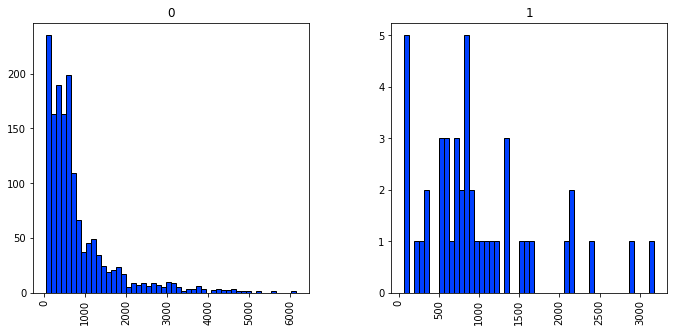

In [5]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
df.hist(column='length', by='label', bins=50,figsize=(11,5))

*Tworzymy funkcję która usunie znaki interpunkcyjne i tzw. stop words z podanego przez nas tekstu*

In [6]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

*Poddajemy nasz tekst wiadomości wstępnemu przetworzeniu przy użyciu stworzonej wyżej funkcji*

In [7]:
text_feat = df['message'].copy()
text_feat = text_feat.apply(text_process)

*Poddajemy go następnie transformacji TFIDF*

In [8]:
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(text_feat)

*Tak stworzony zestaw danych wejściowych (features) i ich klas (labels) dzielimy na zbiór treningowy i testowy*

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=111)

*Tworzymy całą gamę klasyfikatorów w celu porównania jak poszczególne z nich dokonują klasyfikacji wskazanego przez nas tekstu* 

In [10]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

*Tworzymy funkcje która utworzy nam model dla danego przez nas klasyfikatora*

In [11]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)

*Druga funkcja dokona klasyfikacji i zwróci wynik prognozy*

In [12]:
def predict_labels(clf, features):
    return (clf.predict(features))

*Przy użyciu stworzonych funkcji budujemy poszczególne modele i dokonujemy klasyfikacji przy ich pomocy. Wynik zapisujemy w tabeli*

In [13]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

*Wynik pokazuje, że najlepszymi klasyfikatorami są: Drzewa Decyzyjne (DecisionTreeClassifier) oraz Drzewa Decyzyjne z bootstrapingiem (BaggingClassifier)*

In [14]:
dfOut = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
dfOut

,Score
RF,0.972163
KN,0.974304
ETC,0.972163
AdaBoost,0.995717
DT,1.000000
BgC,1.000000
LR,0.985011
SVC,0.985011
NB,0.972163


*Precyzja (accuracy) dla poszczególnych klasyfikatorów*

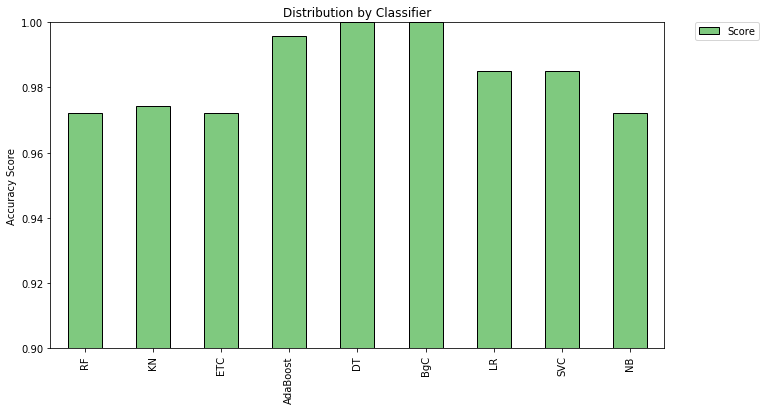

In [15]:
dfOut.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), dfOut.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

*Drugą część analizy rozpoczynamy od zdefiniowania funkcji stemmer odpowiedzialnej za stemming czyli usuwanie końcówek fleksyjnych wyrazów*

In [16]:
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

*Przetwarzamy nasz tekst przy użyciu tej funkcji oraz dokonujemy transformacj Tfidf*

In [17]:
text_feat = text_feat.apply(stemmer)
features = vectorizer.fit_transform(text_feat)

*Znów dzielimy zbiór na dane treningowe i testowe*

In [18]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=111)

*Powtarzamy cykl uczenia i predykcji tym razem operując na danych ze stemmingiem. Zobaczymy jaki to będzie miało wpływ na nasze wyniki*

In [19]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

*Wynik wskazuje na nieznaczne pogorszenie się precyzji*

In [20]:
df2 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['+Stemmer'])
dfOut = pd.concat([dfOut,df2],axis=1)
dfOut

,Score,+Stemmer
RF,0.972163,0.972163
KN,0.974304,0.974304
ETC,0.972163,0.972163
AdaBoost,0.995717,0.991435
DT,1.000000,0.995717
BgC,1.000000,0.995717
LR,0.985011,0.980728
SVC,0.985011,0.985011
NB,0.972163,0.972163


*Wykres pokazuje uzyskane wyniki bez i z stemmingiem*

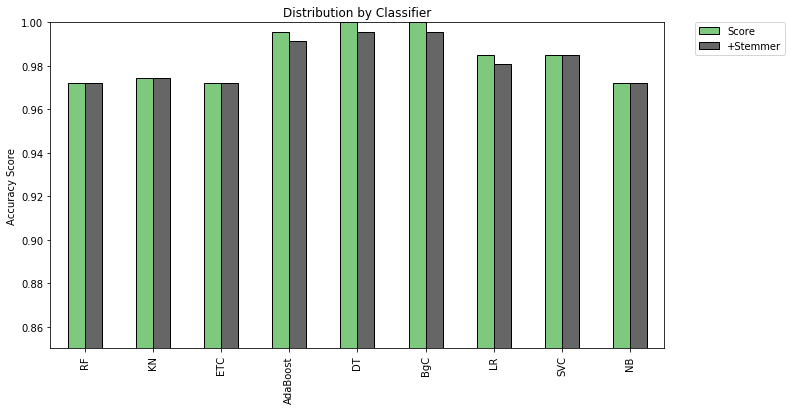

In [21]:
dfOut.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), dfOut.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

*Na początku zauważyliśmy, że klasy różnią się rozkładem długości tekstu. Spróbujmy wykorzystać tą cechę*

In [22]:
lf = df['length'].as_matrix()
newfeat = np.hstack((features.todense(),lf[:, None]))

*Postępujemy jak poprzednio - podział na dane treningowe i budowa modelu*

In [23]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat, labels, test_size=0.3, random_state=111)

pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

*Mamy już do porównania 3 metody - każda wprowadzająca dodatkową cechę lub przekształcenie *

In [24]:
df3 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['+Stemmer +Length'])
dfOut = pd.concat([dfOut,df3],axis=1)
dfOut

,Score,+Stemmer,+Stemmer +Length
RF,0.972163,0.972163,0.972163
KN,0.974304,0.974304,0.972163
ETC,0.972163,0.972163,0.974304
AdaBoost,0.995717,0.991435,0.993576
DT,1.000000,0.995717,0.991435
BgC,1.000000,0.995717,0.995717
LR,0.985011,0.980728,0.982869
SVC,0.985011,0.985011,0.972163
NB,0.972163,0.972163,0.972163


*Wykres tym razem zawiera już 3 nasze metody*

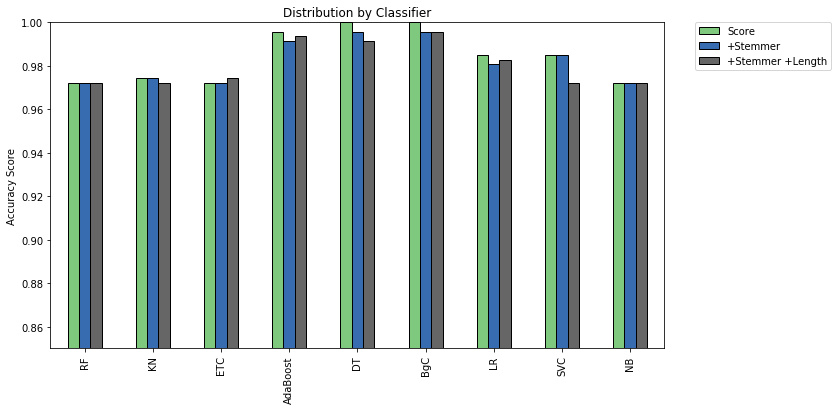

In [25]:
dfOut.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), dfOut.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

*Przechodzimy do wyliczenia precyzji dla modelu z głosowaniem. Uzyskujemy wartość 0.9850 podczas gdy średnia z poszczególnych metod wynosi 0.9839. Czyli teoria mówiąca, że w metodzie z głosowaniem uzyskujemy lepszy wynik niż wynika to z poszczególnym metod potwierdza się w naszym przypadku*

In [26]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')
eclf.fit(features_train,labels_train)
pred = eclf.predict(features_test)
print(accuracy_score(labels_test,pred))

0.985010706638


*Budowa modelu to jedno ale jego realne możliwości predykcyjne to drugie. Zobaczmy jaką precyzje uzyskamy dla danych testowych które nie brały udziału w uczeniu modelu*

In [27]:
data_test = []

with open("./data/ReutersCorn-test.csv") as f:
    for line in f:
        row = []
        row.append(line[1:-4])
        row.append(line[-2:-1])
        data_test.append(row)
        
dfTest = pd.DataFrame(data_test, columns = ['message','label'])
dfTest.head()

,message,label
0,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,0
1,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,0
2,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,0
3,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Tha...,1
4,INDONESIA SEES CPO PRICE RISING SHARPLY Indone...,0


*Wyodrębniamy klasy*

In [28]:
test_labels = dfTest['label']

*Kolejno: wyodrębniamy długości tekstów, tworzymy kopię tekstu i przetwarzamy tekst przy użyciu funkcji text_process*

In [29]:
dfTest['length'] = dfTest['message'].apply(len)
text_feat_test = dfTest['message'].copy()
text_feat_test = text_feat_test.apply(text_process)

*Dokonujemy transformacji Tfidf a następnie dodajemy długość tekstu do danych wejściowych*

In [30]:
features_test = vectorizer.transform(text_feat_test)
lft = dfTest['length'].as_matrix()
newfeatTest = np.hstack((features_test.todense(),lft[:, None]))

*Przy użyciu stworzonego wcześniej modelu z głosowaniem dokonujemy predykcji. Uzyskana precyzja 97% jest wysoką wartością*

In [31]:
pred_test = eclf.predict(newfeatTest)
print(accuracy_score(test_labels,pred_test))

0.973509933775


*Ale czy jest aż tak dobrze? Rzut okiem na ACC (parametr który rozpatrywaliśmy dotychczas) - jest ok*

*TNR (True Negative Rate) – określa zdolność klasyfikatora do wykrywania klasy negatywnej - jest idealnie - klasyfikator zawsze bezbłędnie wskazał klasę negatywną*

*TPR (True Positive Rate) – określa zdolność klasyfikatora do wykrywania klasy pozytywnej - no i tutaj już nie jest dobrze - jedynie w jednym na trzy przypadki klasyfikator sie nie pomylił.*

*Czemu tak się sało? Odpowiedz na to pyatnie można znaleźć w liczebności grup. Jedynie niespełna 3% posiadanych danych to klasa 1 i ta dyspropocja zaważyła na tym, że klasyfikator tak dobrze rozpoznaje klasę 0 a tak słabo klasę 1*

In [32]:
from sklearn.metrics import (precision_score, recall_score, confusion_matrix, f1_score)

y_test = np.array(test_labels).astype(int)
y_pred = pred_test.astype(int)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
se = tp / (tp + fn)
sp = tn / (tn + fp)
acc = (tp + tn) / (tp + tn + fp + fn)

print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

print("\tTPR: %f" % tpr)
print("\tTNR: %f" % tnr)
print("\tFPR: %f" % fpr)
print("\tFNR: %f" % fnr)
print("\tSE:  %f" % se)
print("\tSP:  %f" % sp)
print("\tACC: %f" % acc)


	Precision: 1.000
	Recall: 0.333
	F1: 0.500

	TPR: 0.333333
	TNR: 1.000000
	FPR: 0.000000
	FNR: 0.666667
	SE:  0.333333
	SP:  1.000000
	ACC: 0.973510


*Dla dopełnienia analizy krzywa ROC*

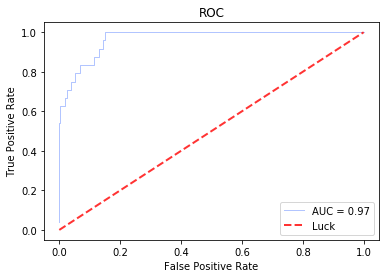

In [33]:
from sklearn.metrics import (roc_curve, auc)

probas_  = eclf.predict_proba(newfeatTest)

fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()